In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -r "/content/drive/MyDrive/Project 2 Dataset" "/content/"

In [3]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Project 2 Dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4327 files belonging to 5 classes.


In [6]:
class_name = dataset.class_names
class_name

['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip']

In [7]:
len(dataset)

136

In [8]:
136*32

4352

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 4 2 1 1 3 0 4 1 0 0 3 0 1 3 4 4 0 2 3 1 1 4 2 4 0 4 0 4 4 2 3]


In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[ 72.375       77.25         0.875     ]
  [ 68.875       72.           1.125     ]
  [ 58.25        67.           1.75      ]
  ...
  [101.875       16.875       21.375     ]
  [121.25        10.625       12.625     ]
  [215.75        13.125       23.875     ]]

 [[ 71.72046     82.579834     1.9035645 ]
  [ 53.820557    67.79224      8.698975  ]
  [ 56.286377    60.92212      0.44091797]
  ...
  [114.872314    14.911377    22.871094  ]
  [182.40283     17.544434    23.00415   ]
  [189.56836     18.267822    21.724365  ]]

 [[ 72.732666    75.74634      9.065918  ]
  [ 46.502197    61.661865     5.1591797 ]
  [ 46.48877     60.687744     0.7976074 ]
  ...
  [163.771       14.757568    20.03955   ]
  [201.83984     22.92041     27.152588  ]
  [180.67749     23.552979    25.278076  ]]

 ...

 [[138.0708     117.4458     135.95337   ]
  [209.12842    200.77563    212.74805   ]
  [182.44019    173.50024    200.89746   ]
  ...
  [ 83.63281      9.1640625    6.967041  ]
  [103.09448     1

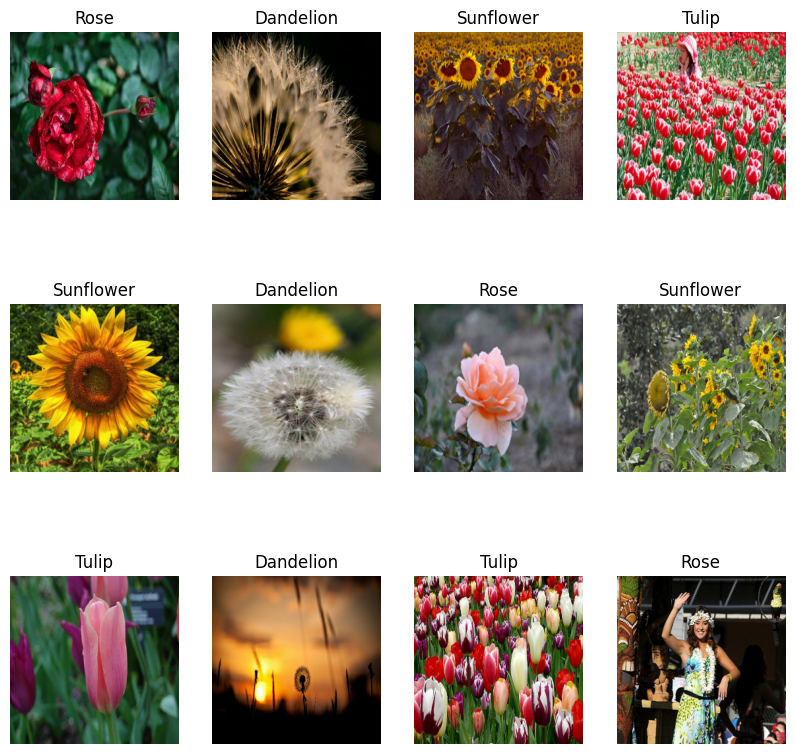

In [11]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8')) #show 3d array
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)

136

In [13]:
#80% ==> training
#20% ==> 10% validation, 10% test

In [14]:
train_size= 0.8
len(dataset)*train_size

108.80000000000001

In [15]:
train_ds = dataset.take(108)
len(train_ds)

108

In [16]:
test_ds = dataset.skip(108)
len(test_ds)

28

In [17]:
val_size=0.1
len(dataset)*val_size

13.600000000000001

In [18]:
val_ds = test_ds.take(13)
len(val_ds)

13

In [19]:
test_ds = test_ds.skip(13)
len(test_ds)

15

In [20]:
def get_dataset_partitions_tf(ds, train_split= 0.8, val_split= 0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds

In [21]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
108/108 [==============================] - 44s 176ms/step - loss: 1.3105 - accuracy: 0.4159 - val_loss: 1.1342 - val_accuracy: 0.5024
Epoch 2/30
108/108 [==============================] - 7s 62ms/step - loss: 1.1157 - accuracy: 0.5264 - val_loss: 1.0607 - val_accuracy: 0.5865
Epoch 3/30
108/108 [==============================] - 7s 62ms/step - loss: 1.0450 - accuracy: 0.5651 - val_loss: 0.9462 - val_accuracy: 0.6226
Epoch 4/30
108/108 [==============================] - 7s 61ms/step - loss: 0.9934 - accuracy: 0.5960 - val_loss: 0.9834 - val_accuracy: 0.6034
Epoch 5/30
108/108 [==============================] - 7s 62ms/step - loss: 0.9357 - accuracy: 0.6237 - val_loss: 0.9033 - val_accuracy: 0.6274
Epoch 6/30
108/108 [==============================] - 7s 60ms/step - loss: 0.9267 - accuracy: 0.6229 - val_loss: 0.9002 - val_accuracy: 0.6442
Epoch 7/30
108/108 [==============================] - 7s 62ms/step - loss: 0.8737 - accuracy: 0.6526 - val_loss: 0.8339 - val_accuracy: 0.68

In [29]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 11s 26ms/step - loss: 0.5817 - accuracy: 0.7792


In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 108}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
type(history.history['loss'])

list

In [35]:
len(history.history['loss'])

30

In [36]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.310487151145935,
 1.1156725883483887,
 1.0450432300567627,
 0.9934004545211792,
 0.9356989860534668]

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

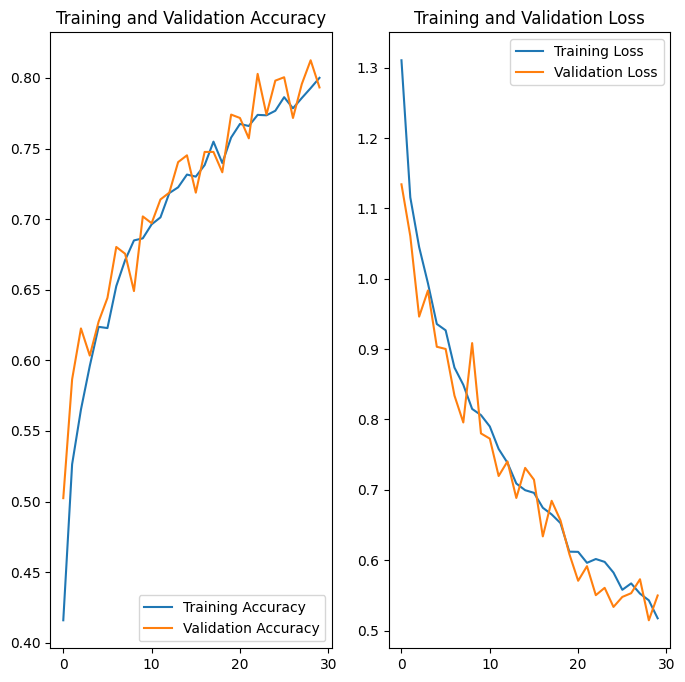

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tulip
1/1 [==============================] - 0s 475ms/step
predicted label: Tulip


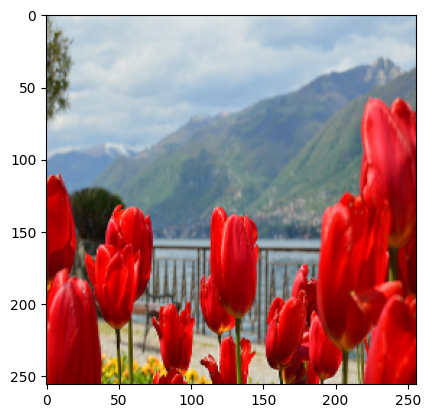

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


Output hidden; open in https://colab.research.google.com to view.

In [42]:
import pickle

In [44]:
model_filename = 'flower_classification_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

In [45]:
with open(model_filename, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

In [50]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/model") + [0]])+1
model.save(f"/content/drive/MyDrive/model/{model_version}")